<!--# GrandPrix: Scaling up the Bayesian GPLVM with informative prior-->
# Applying GrandPrix to the *Arabidopis thaliana* microarray data
_Sumon Ahmed_, 2017

<!--The sparse variational inference of the Bayesian GPLVM allows the computation of an exact lower bound of the marginal log likelihood $\log p(Y|\theta)$ by variationaly integrating out the input/latent variables of the GP. 
-->
This notebooks depicts how GrandPrix with informative prior over the latent space can be used to infer one dimensional pseudotime from microarray data.   

In [1]:
import pandas as pd
import numpy as np
from  GrandPrix import GrandPrix

## Data decription
<a href="https://www.ncbi.nlm.nih.gov/pubmed/23023172" terget="_blank">Windram et al. (2012)</a> analysed the effects of Botrytis cinera infection on *Arabidopis
thaliana*. The generated time series contained __24__ distinct capture time points for both infected and control conditions. 

The __WindramTrainingData.csv__ contains the expression profiles of the __100__ genes of the __24__ time points in infected conditions which have been used in the inference.

The __WindramMetaData.csv__ contains the additional information of the data such as capture time of each cells, different initializations of latent space, etc.

In [2]:
Y = pd.read_csv('../data/Windram/WindramTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('../data/Windram/WindramMetaData.csv', index_col=[0])

In [3]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


In [4]:
mData.head()

,cell,obstime,condition,capture,obstime.orig,capture.orig,init_1,init_2,init_3,init_4,...,init_11,init_12,init_13,init_14,init_15,init_16,init_17,init_18,init_19,init_20
1,GSM734540,6,Botrytis,6,2,2,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,8.478261,8.478261
2,GSM734541,6,Botrytis,6,4,4,4.826087,4.826087,4.826087,4.826087,...,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,12.130435,12.130435
3,GSM734542,6,Botrytis,6,6,6,8.478261,6.652174,6.652174,6.652174,...,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,3.000000,10.304348
4,GSM734543,6,Botrytis,6,8,8,6.652174,10.304348,10.304348,8.478261,...,8.478261,10.304348,10.304348,10.304348,8.478261,8.478261,8.478261,10.304348,6.652174,6.652174
5,GSM734544,6,Botrytis,6,10,10,10.304348,8.478261,8.478261,10.304348,...,10.304348,8.478261,8.478261,8.478261,10.304348,10.304348,10.304348,8.478261,13.956522,3.000000


## Model with Informative prior

Capture time points have been used as the informative prior information over pseudotime. Following arguments have been passed to initialize the model.

<!--
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.
-  __latent_prior_mean__: _array-like, shape N_ x 1, _optional (default:_ __0__). > Mean of the prior distribution over pseudotime.
-  __latent_prior_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Variance of the prior distribution over pseudotime.
-  __latent_mean__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial mean values of the approximate posterior distribution over pseudotime.
-  __latent_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial variance of the approximate posterior distribution over pseudotime.
- __kernel:__ _optional (default: RBF kernel with lengthscale and variance set to 1.0)_. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior. 

-->
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_var__: _array-like, shape N_ x 1. Variance of the prior distribution over pseudotime.


-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.


-  __latent_var__: _array-like, shape N_ x 1. Initial variance of the approximate posterior distribution over pseudotime.


- __kernel:__. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior.

In [5]:
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)] 

In [6]:
pt_wp, var_wp = GrandPrix.fit_model(data=Y, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t), 
                                    latent_mean=np.asarray(X_mean),  latent_var=np.square(sigma_t),
                                    kernel={'name':'Matern32', 'ls':18.0, 'var':1.0})

Could not find signature for _expectation: <Gaussian, Matern32, NoneType, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, Matern32, InducingPoints>


/home/sumon/newInstall/GPflow/gpflow/expectations.py:110: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1768.381846
  Number of iterations: 264
  Number of functions evaluations: 301


## Model without using Informative prior
-  Only observed data points have been used.

In [7]:
np.random.seed(10)
pt_np, var_np = GrandPrix.fit_model(data=Y, kernel={'name':'Matern32', 'ls':1.0, 'var':1.0}, display=True)

Could not find signature for _expectation: <Gaussian, Matern32, NoneType, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, Matern32, InducingPoints>


/home/sumon/newInstall/GPflow/gpflow/expectations.py:110: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1799.898233
  Number of iterations: 671
  Number of functions evaluations: 698


## Visualize the results
Estimated pseudotimes have been plotted against the actual cell capture times to visualize the correspondence between them. Each point represents a time point.

-  The points are coloured according to the actual cell capture time. 

In [8]:
%matplotlib inline
from utils import plot
from matplotlib import pyplot as plt

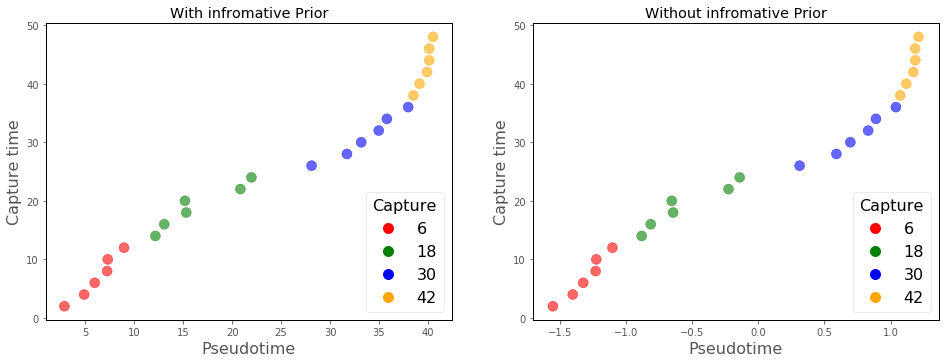

In [9]:
actual_capture_time = mData['capture.orig'].values
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 12))
plt.subplot(2, 2, 1)
plot('With infromative Prior', 'Pseudotime', 'Capture time', pt_wp, actual_capture_time, mData['capture'].values)
plt.subplot(2, 2, 2)
plot('Without infromative Prior', 'Pseudotime', 'Capture time', -pt_np, actual_capture_time, mData['capture'].values)

## Comparison to the <a href="https://github.com/JohnReid/DeLorean" target="_blank" style="text-decoration:none;"> DeLorean Model</a>
* $20$ different initializations have been used
* Models have been compared for varying number of inducing points in terms of -
> * the rank correaltions between actual capture time and estimated pseudotimes
> * the fitting times required 

In [10]:
from utils import plot_comparison

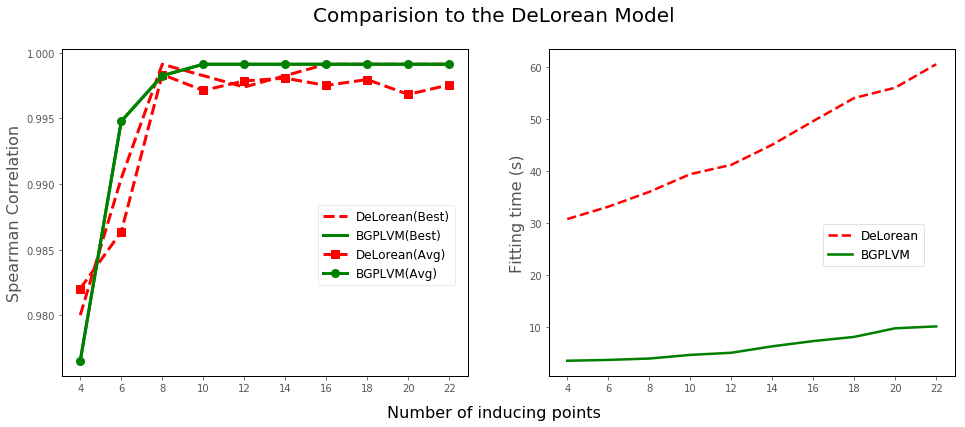

In [11]:
plotDf = pd.read_csv('../data/Windram/WindramDeLorean.csv', index_col=[0])
plot_comparison(plotDf)

## Roughness
Roughness for a particular gene is defined in <a href="https://www.ncbi.nlm.nih.gov/pubmed/27318198" target="_blank">DeLorean</a> as 
$$\frac{1}{\sigma_g} \sqrt{ \frac{1}{C-1} 
\sum_{c=1}^{C-1} \left(x_{g, z_c} - x_{g, z_{c+1}} \right)^2 }$$
where
* $\sigma_g$ the standard deviation of gene expression
* $x_{g, z_c}$ is the gene expression for gene $g$ at pseudotime order $z_c$

This metric measures the smoothness of the gene expression profile by looking at the differences of consecutive measurements. Smaller values indicate a smoother response.

The average roughness statistics for 50 heldout genes using different number of inducing points have been noted. The green bars are proportional to the values shown. 

In [12]:
plotDf[['inducingPoints','GPLVM_avg_roughness']].style.bar(color='lightgreen')

,inducingPoints,GPLVM_avg_roughness
1,4,0.73674
2,6,0.712965
3,8,0.709486
4,10,0.706149
5,12,0.706149
6,14,0.706149
7,16,0.706149
8,18,0.706149
9,20,0.706149
10,22,0.706149
